https://towardsdatascience.com/visualising-similarity-clusters-with-interactive-graphs-20a4b2a18534

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
import uniprot
import plotly
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")

#replace categorical feature with index labeling
df['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

#differentiate other categorical features from the numerical ones
pheno = df.loc[:,'RID':'VISCODE']
data = df.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']

# First, standardize dataset

data['binary_class'] = df['binary_class']
data['three_class'] = df['three_class']
X = data.drop(columns = ['binary_class','three_class'])
y = data["three_class"]

In [3]:
def rfe_xgb(X_train, y_train,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    min_features_to_select = 50
    
    #run RFE on current train subset
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)
    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])

    plt.figure()
    lines = []
    for i in range(rfecv.grid_scores_.shape[1]):
        lines.append(plt.plot(rfecv.grid_scores_[:,i]))

    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.legend(lines,labels = ['fold 1', 'fold 2', 'fold 3','fold 4', 'fold 5'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return newX_train

We kept 74 features out of the 320


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

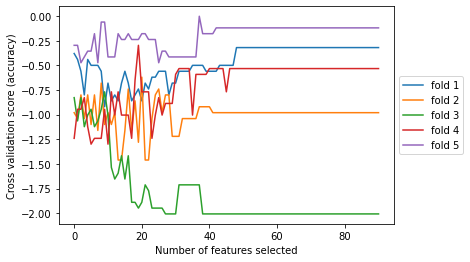

In [4]:
#get selected features from RFE
newX = rfe_xgb(X, y,0,0,0,0,0,0,0,simple=True)

In [5]:
#compute similarity using cosine
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(newX)

In [6]:
import networkx as nx

# create nx graph from sim matrix
G = nx.to_networkx_graph(similarity_matrix)

In [7]:
#interactive slider which specifies the minimum similarity threshold, 
#such that edges with a weight lower than the threshold are not displayed.
def filter_similarity_matrix_at_step(square_matrix, step_value):
    # copy matrix
    aux = square_matrix.copy()
    
    # set as NaN all values equal to or below threshold value
    aux[aux <= step_value] = np.nan
    
    # return filtered matrix
    return aux

In [8]:
def get_interactive_slider_similarity_graph(square_matrix, slider_values, node_text=None, yaxisrange=None, xaxisrange=None):
    
    # Create figure with plotly
    fig = go.Figure()

    # key: slider value
    # value: list of traces to display for that slider value
    slider_dict = {}
    
    # total number of traces
    total_n_traces = 0
    
    # node positions on plot
    #node_pos = None

    # for each possible value in the slider, create and store traces (i.e., plots)
    for i, step_value in enumerate(slider_values):

        # update similarity matrix for the current step
        aux = filter_similarity_matrix_at_step(square_matrix, step_value)

        # create nx graph from sim matrix
        G = nx.to_networkx_graph(aux)
        
        # remove edges for 0 weight (NaN)
        G.remove_edges_from([(a, b) for a, b, attrs in G.edges(data=True) if np.isnan(attrs["weight"])])

        # assign node positions if None
        node_pos = nx.nx_pydot.graphviz_layout(G)

        # populate nodes with meta information
        for node in G.nodes(data=True):
            
            # node position
            node[1]['pos'] = node_pos[node[0]]

            # node color
            node[1]['color'] = "orange"

            # node text on hover if any is specified else is empty
            if node_text is not None:
                node[1]['text'] = node_text[node[0]]
            else:
                node[1]['text'] = ""

        # create edge taces (each edge is a trace, thus this is a list)
        edge_traces = create_edge_trace(G)
        
        # create node trace (a single trace for all nodes, thus it is not a list)
        node_trace = create_node_trace(G) 

        # store edge+node traces as single list for the current step value
        slider_dict[step_value] = edge_traces + [node_trace]
        
        # keep count of the total number of traces
        total_n_traces += len(slider_dict[step_value])

        # make sure that the first slider value is active for visualization
        if i == 0:
            for trace in slider_dict[step_value]:
                # make visible
                trace.visible = True

                
    # Create steps objects (one step per step_value)
    steps = []
    for step_value in slider_values:
        
        # count traces before adding new traces
        n_traces_before_adding_new = len(fig.data)
        
        # add new traces
        fig.add_traces(slider_dict[step_value])

        step = dict(
            # update figure when this step is active
            method="update",
            # make all traces invisible
            args=[{"visible": [False] * total_n_traces}],
            # label on the slider
            label=str(round(step_value, 3)),
        )

        # only toggle this step's traces visible, others remain invisible
        n_traces_for_step_value = len(slider_dict[step_value])
        for i in range(n_traces_before_adding_new, n_traces_before_adding_new + n_traces_for_step_value):
            step["args"][0]["visible"][i] = True
        
        # store step object in list of many steps
        steps.append(step)

    # create slider with list of step objects
    slider = [dict(
        active=0,
        steps=steps
    )]

    # add slider to figure and create layout
    fig.update_layout(
        sliders=slider,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(range=xaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(range=yaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        width=700, height=700,
    )

    return fig


In [12]:
import plotly.graph_objs as go
# define slider steps (i.e., threshold values)
slider_steps = np.arange(0.4, 0.85, 0.05)
    
# get the slider figure
fig = get_interactive_slider_similarity_graph(
    similarity_matrix,
    slider_steps,
    node_text = X
)

# plot it
fig.show()

FileNotFoundError: [WinError 2] "neato" not found in path.